In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#victims = '2022_Victims.csv'
#collisions = '2022_Collisions.csv'

#df1 = pd.read_csv('2022_Victims.csv')
#df2 = pd.read_csv('2022_Collisions.csv')

#merged_df = pd.merge(df1, df2, on='CASE_ID', how='inner')
#

#merged_df.to_csv('2022_Collisions.csv', index=False)

In [3]:
gdf_tracts = gpd.read_file('tracts.geojson')

In [4]:
gdf_bg = gpd.read_file('acs2021_5yr_B01003_15000US060371041082.geojson')

<Axes: >

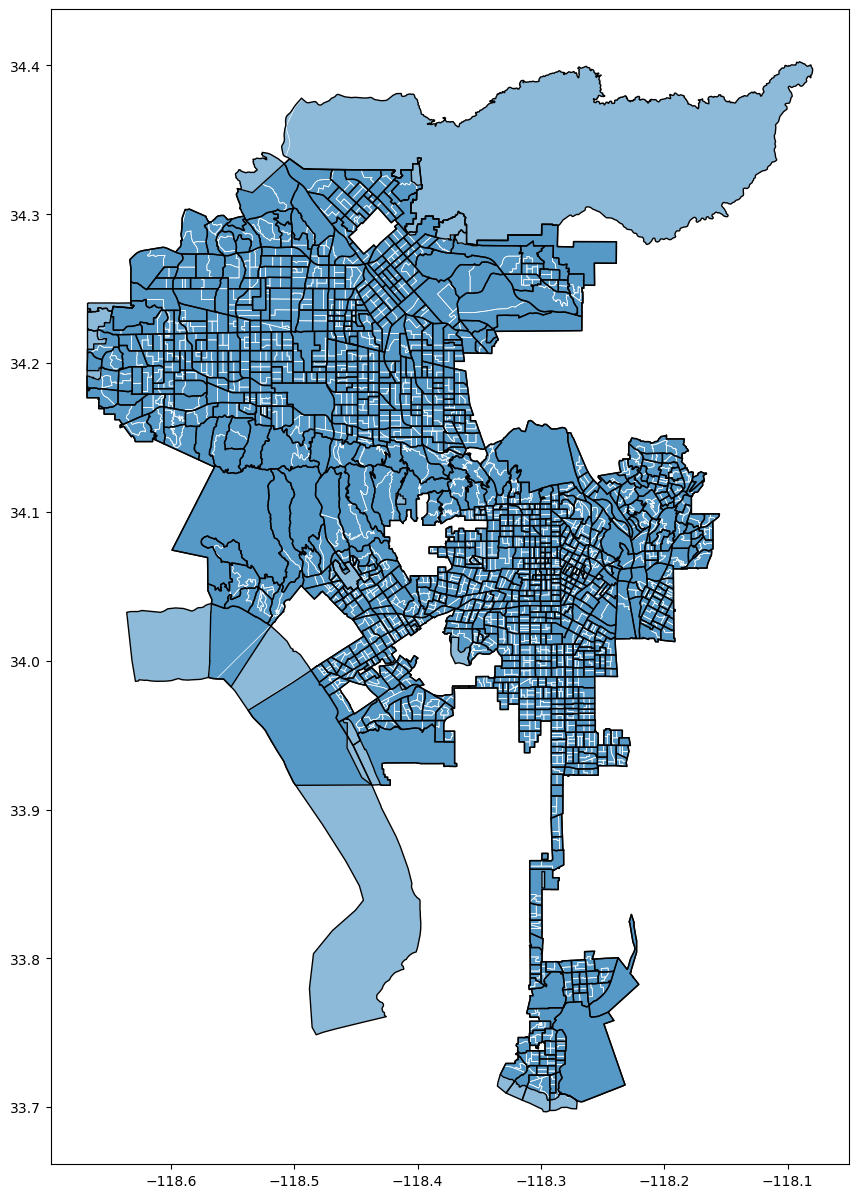

In [5]:
fig,ax = plt.subplots(figsize=(15,15))

gdf_tracts.plot(ax=ax,zorder=10,alpha=0.5)

gdf_bg.boundary.plot(ax=ax,color='white',zorder=15,lw=0.5)

gdf_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

(33.996922999999995, 34.102497)

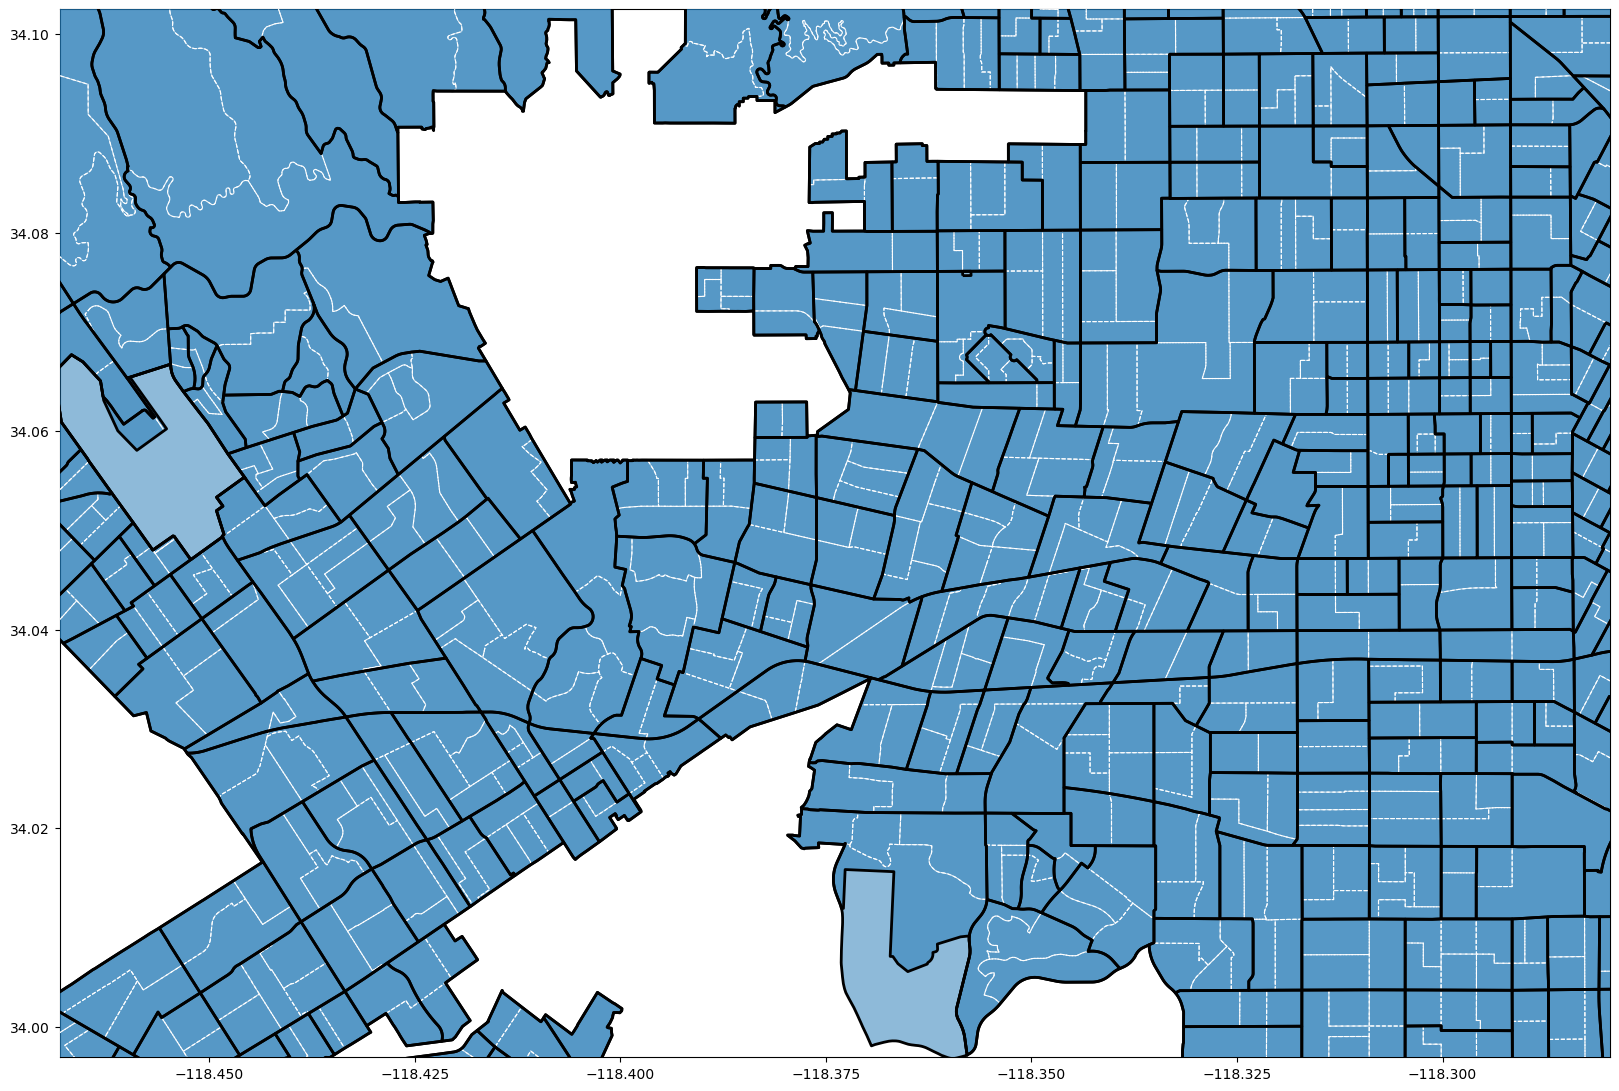

In [6]:
fig,ax = plt.subplots(figsize=(20,15))

gdf_tracts.plot(ax=ax,zorder=10,alpha=0.5)

gdf_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=2)

gdf_bg.boundary.plot(ax=ax,color='white',zorder=15,lw=0.8,linestyle='--')

minx,miny,maxx,maxy = gdf_bg.total_bounds

ax.set_xlim(minx+0.2,maxx-0.2) # zooming in just a bit
ax.set_ylim(miny+0.3,maxy-0.3)

In [7]:
gdf_bg = gdf_bg[['geoid','B01003001','geometry']]
gdf_bg.columns = ['FIPS','TotalPop','geometry']

In [8]:
gdf_bg.drop(gdf_bg.tail(1).index,inplace=True)
gdf_bg['FIPS'] = gdf_bg['FIPS'].str.replace('15000US','')
gdf_bg.sort_values(by='TotalPop').head(20)


FIPS  TotalPop  \
2683  060379902000       0.0   
2682  060379800391       0.0   
2676  060379800221       0.0   
2677  060379800231       0.0   
2247  060372653012       0.0   
2674  060379800201       0.0   
2680  060379800281       0.0   
2668  060379800091       5.0   
2679  060379800261      16.0   
2670  060379800141      44.0   
2675  060379800211      47.0   
2526  060372774002      57.0   
2673  060379800191      66.0   
2525  060372774001     107.0   
2669  060379800101     109.0   
2667  060379800081     150.0   
2678  060379800241     200.0   
691   060371321021     231.0   
925   060371434022     233.0   
1088  060371897041     251.0   

                                               geometry  
2683  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2682  MULTIPOLYGON (((-118.36215 34.13903, -118.3612...  
2676  MULTIPOLYGON (((-118.50266 34.30809, -118.5026...  
2677  MULTIPOLYGON (((-118.64870 34.23120, -118.6480...  
2247  MULTIPOLYGON (((-118.44878 34.06862, -118.4486...  
2674  MULTIPOLYGON (((-118.34414 34.21615, -118.3441...  
2680  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2668  MULTIPOLYGON (((-118.33707 34.14160, -118.3361...  
2679  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2670  MULTIPOLYGON (((-118.26088 33.76850, -118.2602...  
2675  MULTIPOLYGON (((-118.40183 34.26509, -118.4017...  
2526  MULTIPOLYGON (((-118.37868 33.95180, -118.3786...  
2673  MULTIPOLYGON (((-118.59919 34.07436, -118.5991...  
2525  MULTIPOLYGON (((-118.37847 33.94652, -118.3784...  
2669  MULTIPOLYGON (((-118.25165 34.08038, -118.2515...  
2667  MULTIPOLYGON (((-118.50267 34.22121, -118.5015...  
2678  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
691   MULTIPOLYGON (((-118.50114 34.21315, -118.5008...  
925   MULTIPOLYGON (((-118.40526 34.15762, -118.4052...  
1088  MULTIPOLYGON (((-118.34679 34.12896, -118.3467...

In [9]:
gdf_bg = gdf_bg[gdf_bg['TotalPop']>100]

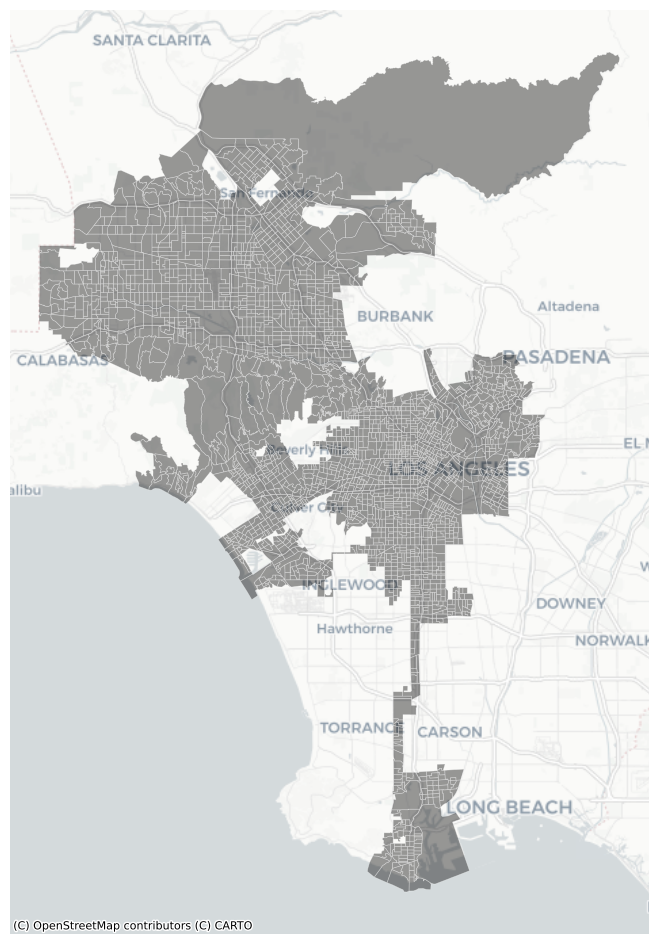

In [10]:
gdf_bg = gdf_bg.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12,12))

gdf_bg.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)


ax.axis('off')


ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [19]:
collisions  =  pd.read_csv('2022_Collisions.csv')
collisions = gpd.GeoDataFrame(collisions, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(collisions.POINT_X, collisions.POINT_Y))

/tmp/ipykernel_1502/297749513.py:1: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions  =  pd.read_csv('2022_Collisions.csv')


In [21]:
collisions = collisions.to_crs(epsg=3857)

In [22]:
collisions['POINT_X'] = collisions['POINT_X'].astype('float')
collisions['POINT_Y'] = collisions['POINT_Y'].astype('float')


In [23]:
collisions = collisions[
    (collisions['POINT_X'] >= -119.243683) &
    (collisions['POINT_X'] <= -116.243683) &
    (collisions['POINT_Y'] >= 33.052235) &
    (collisions['POINT_Y'] <= 36.052235)
]
collisions.to_csv('filtered_collisions.csv', index=False)


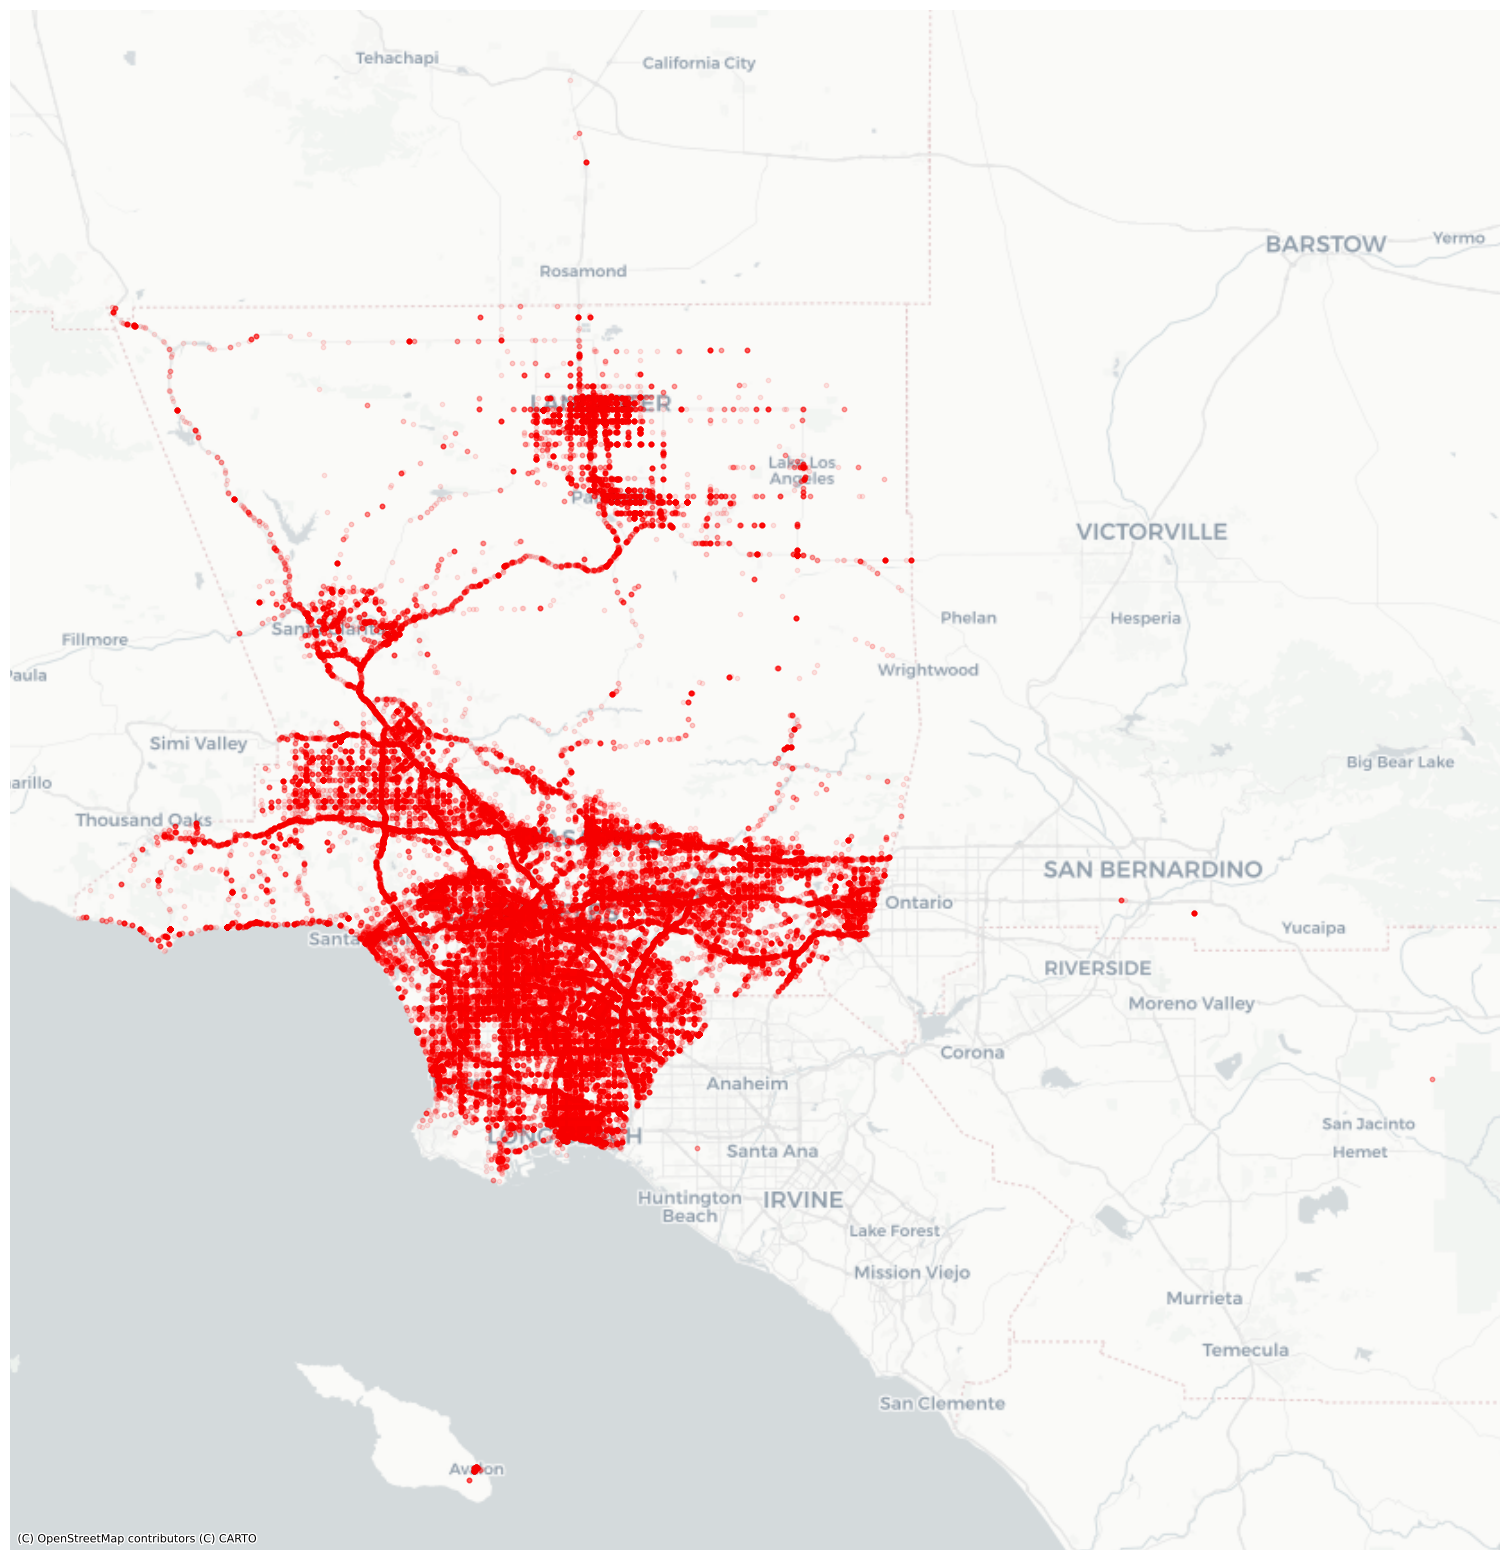

In [24]:
fig,ax = plt.subplots(figsize=(20,20))

collisions.plot(ax=ax,
             color='red',
             markersize=10, alpha=0.1)


ax.axis('off')


ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


In [26]:
minx, miny, maxx, maxy = collisions.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13240242.837191917
-13008961.375607258
3938917.1522523984
4177986.48457637


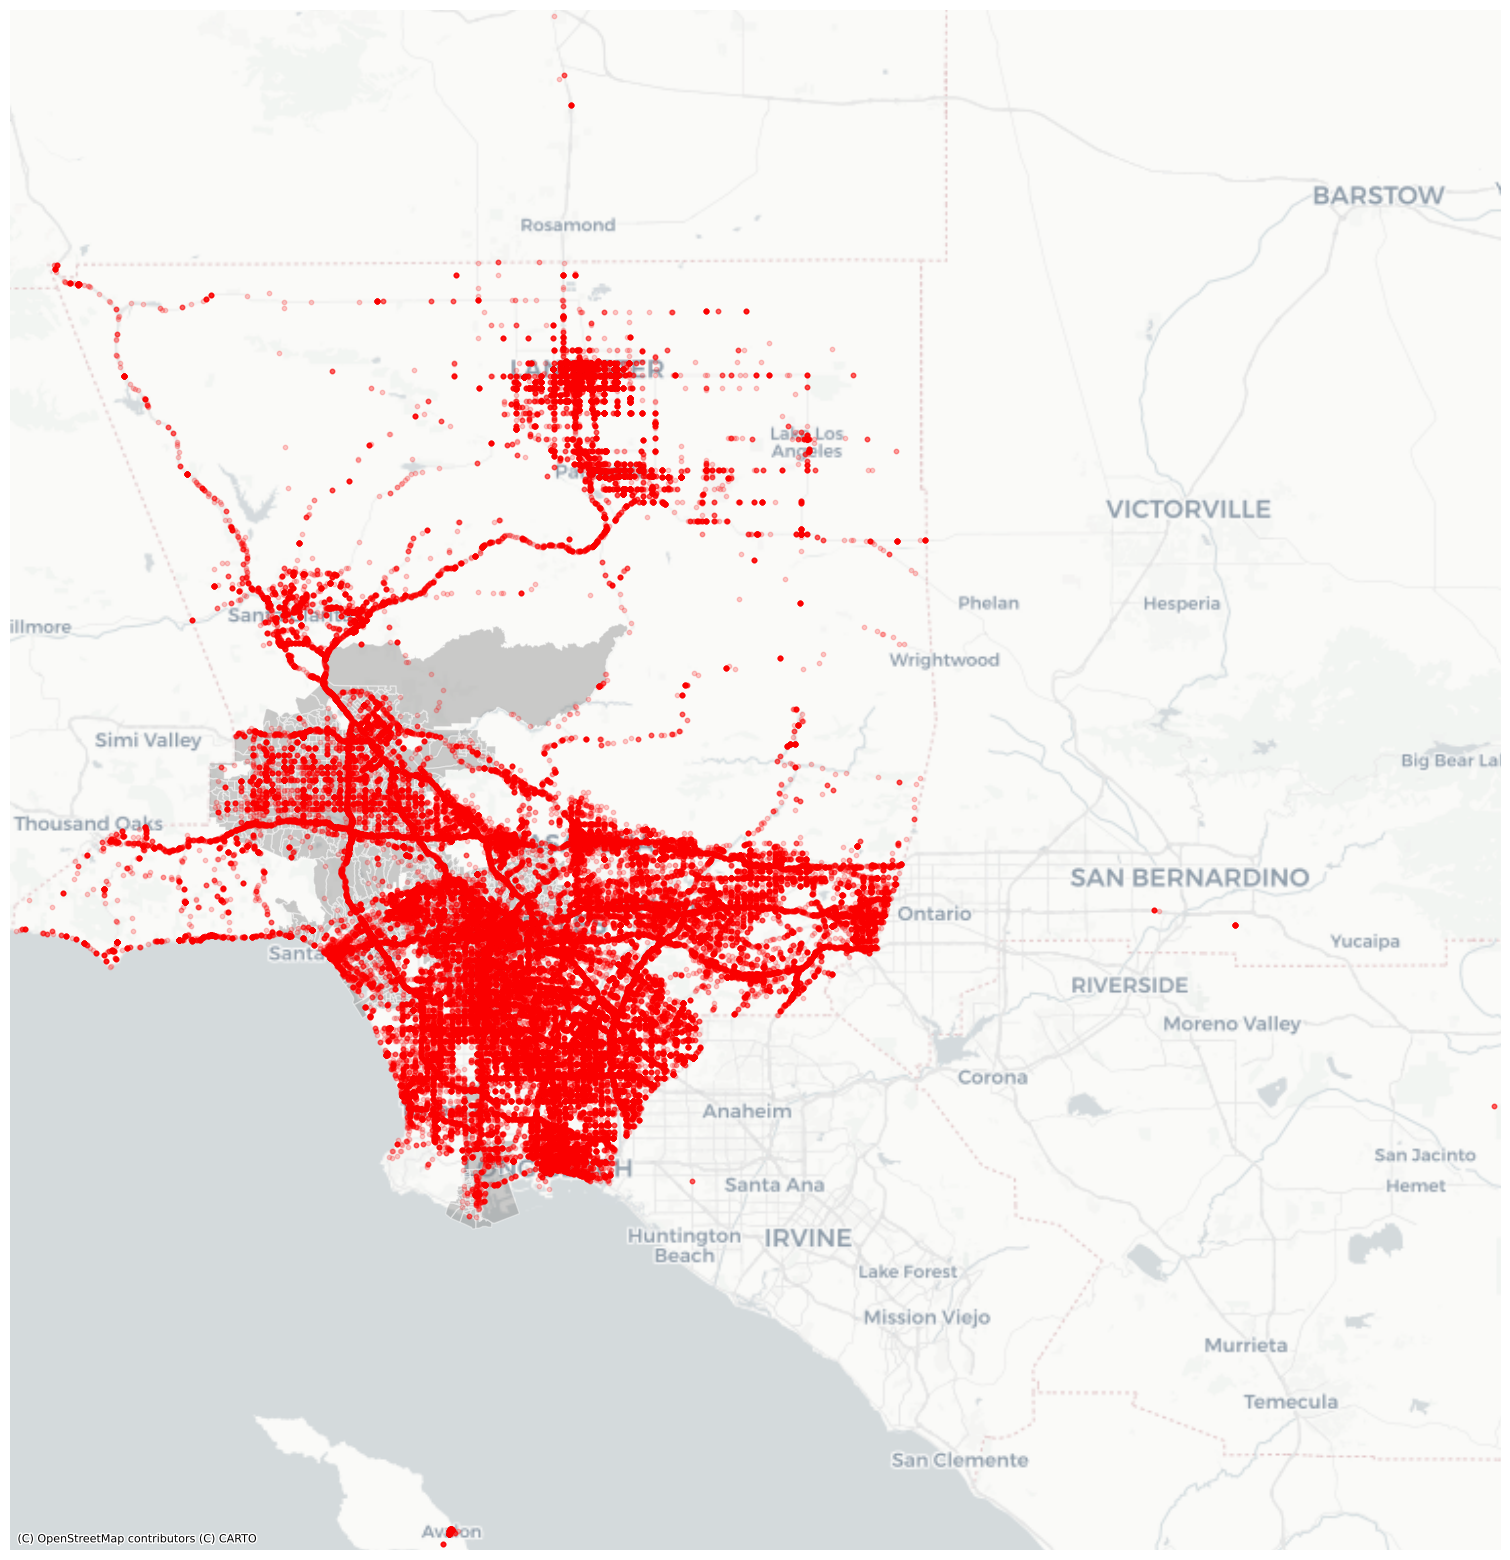

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))


gdf_bg.plot(ax=ax, 
        color='gray', 
        edgecolor='white',
        alpha=0.4)


collisions.plot(ax=ax, 
        color='red',
        markersize=10,
        alpha=0.2)


ax.set_xlim(minx - 1000, maxx + 1000) 
ax.set_ylim(miny - 1000, maxy + 1000)


ax.axis('off')


ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [28]:
join = gpd.sjoin(gdf_bg, collisions, how='left')

In [29]:
join.shape

(39171, 110)

In [52]:
collisions_by_bg = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='collision_count')
collisions_by_bg

FIPS  collision_count
0     060372288002              731
1     060379800241              600
2     060372677002              398
3     060372240202              333
4     060379800101              313
...            ...              ...
2666  060372264202                1
2667  060372264201                1
2668  060371371034                1
2669  060372264101                1
2670  060371011101                1

[2671 rows x 2 columns]

<Axes: xlabel='FIPS'>

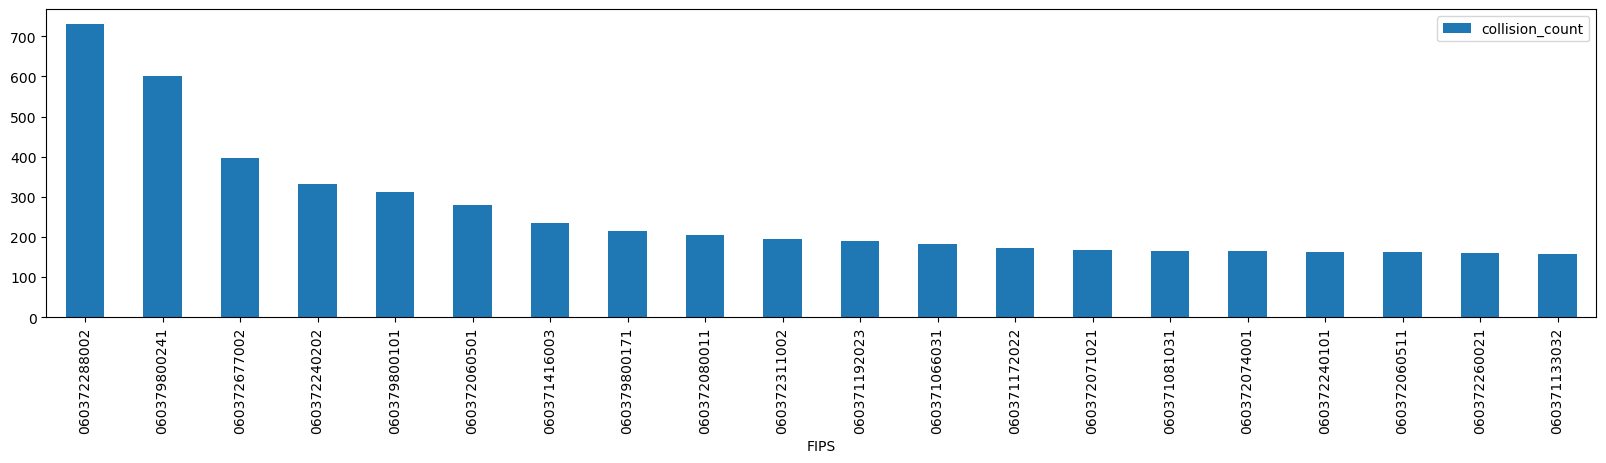

In [53]:
collisions_by_bg[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='collision_count')

In [54]:
gdf_bg=gdf_bg.merge(collisions_by_bg,on='FIPS')

In [55]:
gdf_bg.sample(10)

FIPS  TotalPop  \
1998  060372364003    1409.0   
1418  060372073042     957.0   
1103  060371899072    1216.0   
1886  060372315001    1923.0   
77    060371046201    1459.0   
2078  060372395012    1046.0   
22    060371021071    2451.0   
2337  060372697001    1180.0   
2518  060372770005    1511.0   
551   060371254031    1165.0   

                                               geometry  collision_count_x  \
1998  MULTIPOLYGON (((-13175677.303 4029021.032, -13...                  5   
1418  MULTIPOLYGON (((-13163755.988 4035067.434, -13...                  7   
1103  MULTIPOLYGON (((-13175098.442 4041972.668, -13...                  1   
1886  MULTIPOLYGON (((-13170088.063 4029421.725, -13...                 13   
77    MULTIPOLYGON (((-13182735.849 4063123.267, -13...                  1   
2078  MULTIPOLYGON (((-13165705.637 4025407.239, -13...                 19   
22    MULTIPOLYGON (((-13176652.684 4060992.132, -13...                  8   
2337  MULTIPOLYGON (((-13178706.529 4033500.222, -13...                 35   
2518  MULTIPOLYGON (((-13181042.123 4024984.808, -13...                  1   
551   MULTIPOLYGON (((-13177887.440 4050965.079, -13...                  1   

      collisions_per_1000  collision_count_y  
1998             3.548616                  5  
1418             7.314525                  7  
1103             0.822368                  1  
1886             6.760270                 13  
77               0.685401                  1  
2078            18.164436                 19  
22               3.263974                  8  
2337            29.661017                 35  
2518             0.661813                  1  
551              0.858369                  1

In [57]:
gdf_bg['collisions_per_1000'] = gdf_bg['collision_count_x']/gdf_bg['TotalPop']*1000

In [58]:
gdf_bg.sort_values(by="collisions_per_1000").tail()

FIPS  TotalPop  \
1858  060372288002    2751.0   
1397  060372060511     406.0   
2665  060379800081     150.0   
2666  060379800101     109.0   
2669  060379800241     200.0   

                                               geometry  collision_count_x  \
1858  MULTIPOLYGON (((-13163282.100 4029327.861, -13...                731   
1397  MULTIPOLYGON (((-13162384.420 4030801.699, -13...                163   
2665  MULTIPOLYGON (((-13191656.548 4058543.673, -13...                116   
2666  MULTIPOLYGON (((-13163713.575 4039600.478, -13...                313   
2669  MULTIPOLYGON (((-13193418.068 4053521.172, -13...                600   

      collisions_per_1000  collision_count_y  
1858           265.721556                731  
1397           401.477833                163  
2665           773.333333                116  
2666          2871.559633                313  
2669          3000.000000                600

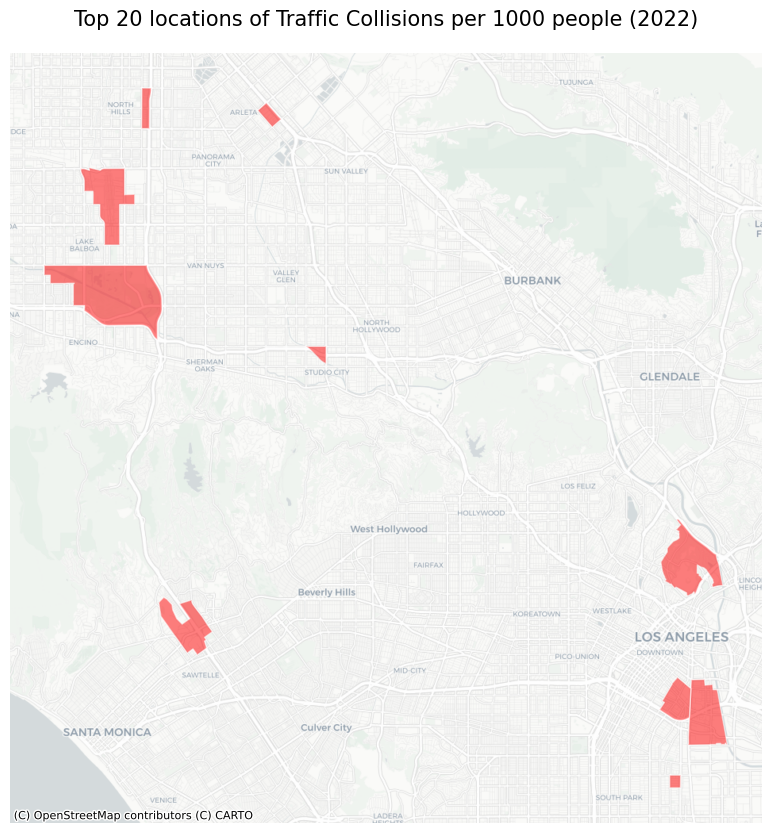

In [59]:
fig,ax = plt.subplots(figsize=(12,10))
gdf_bg.sort_values(by='collisions_per_1000',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5)



ax.set_title('Top 20 locations of Traffic Collisions per 1000 people (2022)',fontsize=15,pad=20)


ax.axis('off')


ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [60]:
#By analyzing the spatial lag of traffic collisions, you can identify clusters of high-risk areas where collisions tend to concentrate.
#These areas might exhibit spatial patterns that could be related to specific factors such as road design, traffic flow, or environmental conditions.

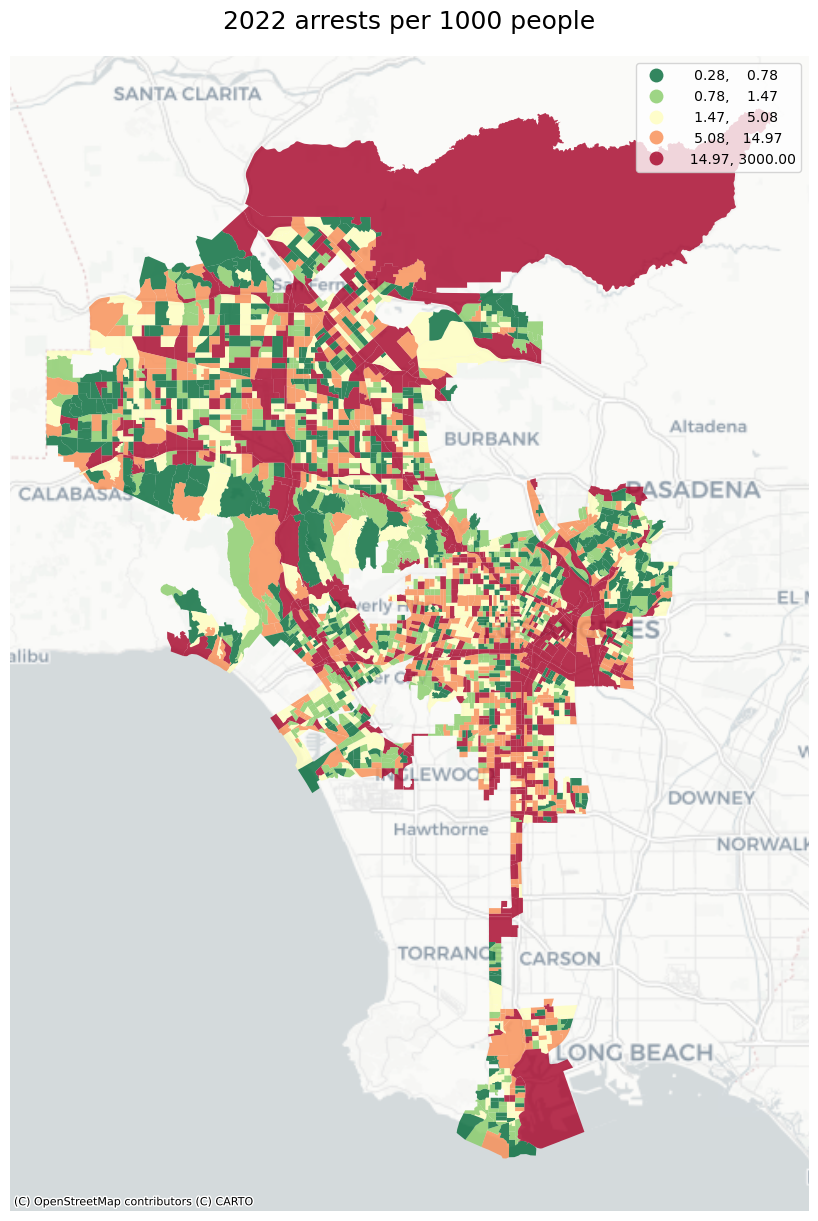

In [61]:
fig,ax = plt.subplots(figsize=(15,15))

gdf_bg.plot(ax=ax,
        column='collisions_per_1000', 
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r', 
        scheme='quantiles')

ax.axis('off')
ax.set_title('2022 arrests per 1000 people',fontsize=18,pad=20)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [73]:
#collisions['collisions_per_1000'] = collisions['collision_count']/gdf['TotalPop']*1000

In [66]:
wq =  lps.weights.KNN.from_dataframe(gdf_bg,k=8)

wq.transform = 'r'

In [67]:
gdf_bg['collisions_per_1000_lag'] = lps.weights.lag_spatial(wq, gdf_bg['collisions_per_1000'])

In [68]:
gdf_bg['collision_lag_diff'] = gdf_bg['collisions_per_1000'] - gdf_bg['collisions_per_1000_lag']

In [69]:
gdf_donut = gdf_bg.sort_values(by='collision_lag_diff').head(1)
gdf_donut

FIPS  TotalPop  \
690  060371321013    1429.0   

                                              geometry  collision_count_x  \
690  MULTIPOLYGON (((-13191483.446 4054251.090, -13...                  1   

     collisions_per_1000  collision_count_y  collisions_per_1000_lag  \
690              0.69979                  1               378.801366   

     collision_lag_diff  
690         -378.101576

In [70]:
gdf_diamond = gdf_bg.sort_values(by='collision_lag_diff').tail(1)
gdf_diamond

FIPS  TotalPop  \
2669  060379800241     200.0   

                                               geometry  collision_count_x  \
2669  MULTIPOLYGON (((-13193418.068 4053521.172, -13...                600   

      collisions_per_1000  collision_count_y  collisions_per_1000_lag  \
2669               3000.0                600                19.957376   

      collision_lag_diff  
2669         2980.042624

In [71]:
y = gdf_bg.collisions_per_1000
moran = Moran(y, wq)
moran.I

0.007940301419257384

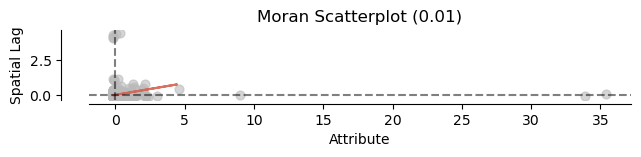

In [72]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.01', ylabel='Density'>)

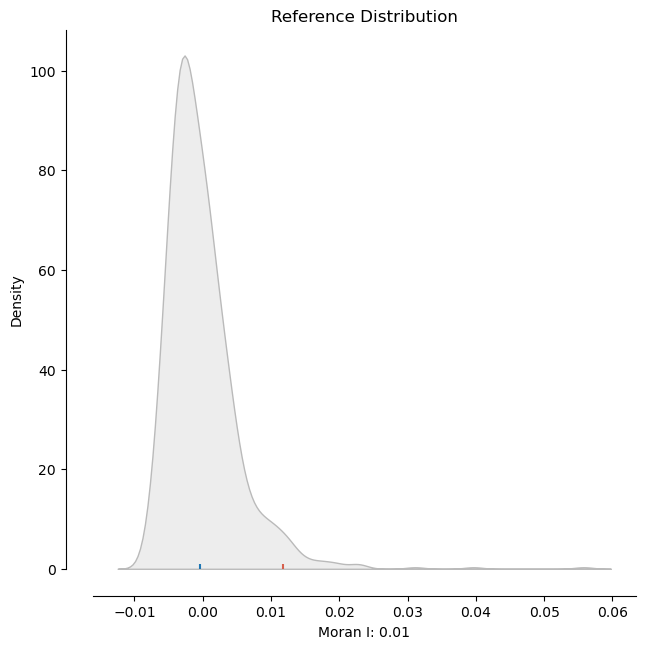

In [68]:
plot_moran_simulation(moran,aspect_equal=False)

In [69]:
moran.p_sim

0.032

In [70]:
lisa = esda.moran.Moran_Local(y, wq)

In [ ]:
#there is positive spatial autocorrelation meaning points that tend to be closer to each other with similar high or low collision counts.

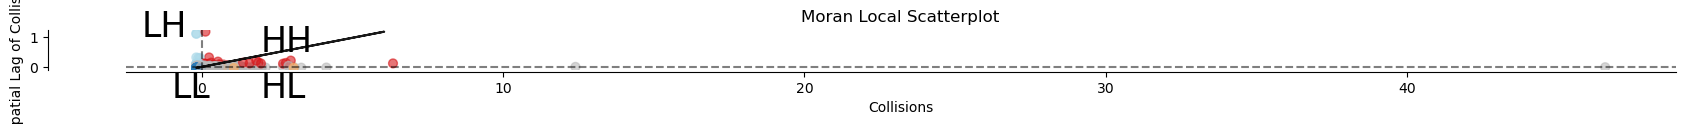

In [73]:
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Collisions")
ax.set_ylabel('Spatial Lag of Collisions')

plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

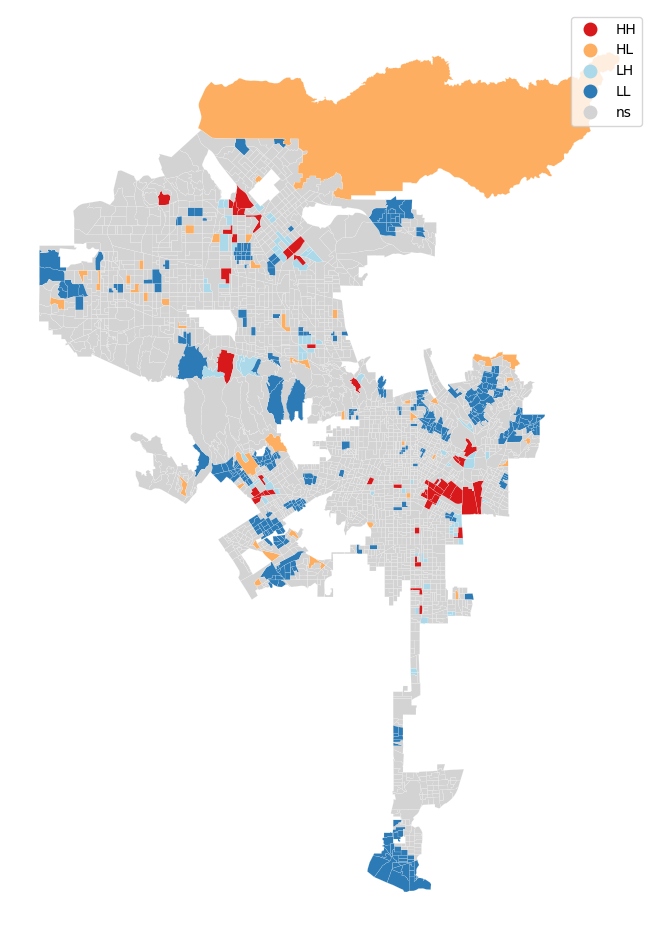

In [74]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_bg, p=0.05, ax=ax)
plt.show()

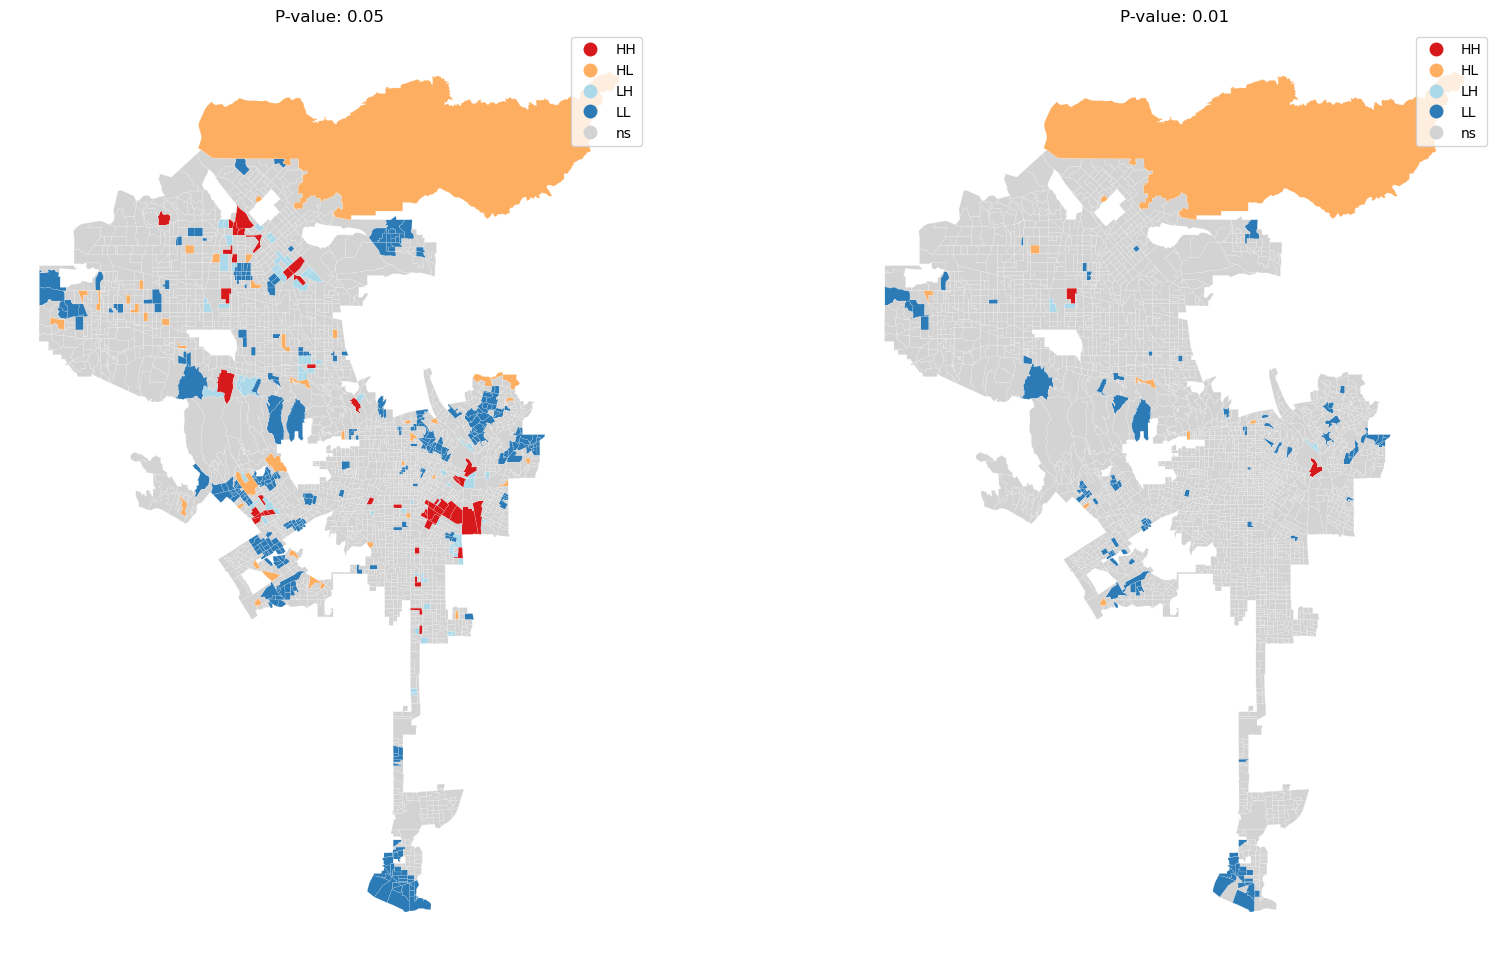

In [75]:

fig, ax = plt.subplots(1, 2, figsize=(20, 12))

lisa_cluster(lisa, gdf_bg, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

lisa_cluster(lisa, gdf_bg, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()